# Reading nexus files (mantid format)
This example looks for data in mantid files, the format is non standard, i.e. no default and signal attributes where found after trying the three alternative algorithms for [locating plottable data](https://manual.nexusformat.org/datarules.html#find-plottable-data).

There are different types of Mantid nexus files. The typed included in the [Mantid training examples](https://sourceforge.net/projects/mantid/files/Sample%20Data/TrainingCourseData.zip/download) are 
- 2D Workspace (these files contain only one signal)
- Event Workspace (these files contain several signals)
- Peaks Workspace
- Grouped Workspaces (the ones found in examples group 2D Workspaces)

## Reading and plotting 2D Workspaces

The first example imports data and plots the contained signal mimicking the behaviour from Mantid "Plot>Spectrum" command

file: C:\Users\scman1\Desktop\MantisData\TrainingCourseData\MUSR00015189_cropped.nxs
{'axis1': ['/mantid_workspace_1/workspace/axis1', 'data'], 'axis2': ['/mantid_workspace_1/workspace/axis2', 'data'], 'errors': ['/mantid_workspace_1/workspace/errors', 'data'], 'values': ['/mantid_workspace_1/workspace/values', 'data']}
4 elements in workspace group
[53. 69. 70. ...  0.  0.  0.] [ 0.11399999  0.13        0.146      ... 29.95400143 29.97000122
 29.98600101]


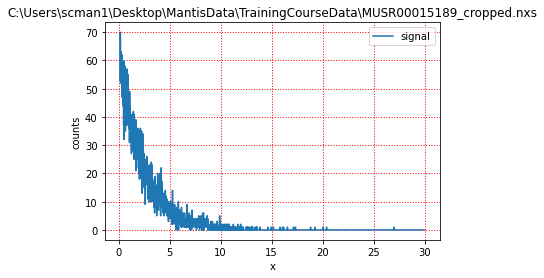

In [8]:
# read nexus file
# from https://manual.nexusformat.org/examples/h5py/

#library for reading nexus HDF5 data files 
import h5py

# ploting library
import matplotlib.pyplot as plt

# system library to get desktop path for current user
import os

# recursively loop on all groups until data is found and print its contents

def look_up_dataset_names(nx_group):
    dataset_names = []
    for group_key in nx_group.keys():
        #stop condition
        if type(nx_group[group_key]) != h5py._hl.group.Group:
            dataset_names.append(nx_group[group_key].name)
        elif type(nx_group[group_key]) == h5py._hl.group.Group:
            dataset_names += look_up_dataset_names(nx_group[group_key])
    return dataset_names

# recursively traverse tree and build tree model
def get_tree(nx_group):
    nx_tree={}
    for group_key in nx_group.keys():
        #stop condition
        if type(nx_group[group_key]) == h5py._hl.dataset.Dataset:
            nx_tree[group_key] = [nx_group[group_key].name, "data"]
        elif type(nx_group[group_key]) == h5py._hl.group.Group:
            nx_tree[group_key] = [get_tree(nx_group[group_key]), "group"]
    return nx_tree


# smallest nexus file from training course
# assume example files are in the current user's desktop
file_path = os.environ['USERPROFILE'] + '\Desktop\MantisData\TrainingCourseData' + "\MUSR00015189_cropped.nxs"

with h5py.File(file_path, "r") as nx:
    print(f"file: {nx.filename}")
    
    nx_tree = get_tree(nx)
    # the first group is the root of the nexus file
    root = list(nx_tree.keys())[0]
    # Mantid workspace2D stores data in workspace root child element
    # look if the groups below root contain workspace
    if "workspace" in nx_tree[root][0].keys():
        print (nx_tree[root][0]['workspace'][0])
        print (len(nx_tree[root][0]['workspace'][0]), "elements in workspace group")
        values_path = nx_tree[root][0]['workspace'][0]['values'][0]
        axis1_path = nx_tree[root][0]['workspace'][0]['axis1'][0]
        axis2_path = nx_tree[root][0]['workspace'][0]['axis2'][0]
        errors_path = nx_tree[root][0]['workspace'][0]['errors'][0]
        y_vals = nx[values_path][()][0] # plottable values
        a1_vals = nx[axis1_path][()] # bucket markers
        a2_vals = nx[axis2_path][()]
        er_vals = nx[errors_path][()] # error values
        # get the middle of buckets
        lower = a1_vals[()][:-1]
        upper = a1_vals[()][1:]
        mid_b = lower + (upper - lower)/2
        print (y_vals, mid_b)
        # plot(x,y, label)
        plt.plot(mid_b, y_vals, label='signal')
        plt.xlabel('x')
        plt.ylabel('counts')
        plt.legend() # include the leyend in the plot
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.title(nx.filename)
        #plt.show()


In [2]:
# version 2 axes attribute
# 1 Start at the top level of the NeXus data file (the root of the HDF5 hierarchy).
# 2 Loop through the groups with class NXentry until the next step succeeds.
# 3 Open the NXentry group and loop through the subgroups with class NXdata until the next step succeeds.
# 4 Open the NXdata group and loop through the fields for the one field with attribute signal="1". 
#   Note: There should be only one field that matches.
with h5py.File(filename, "r") as nx:
    print(f"file: {nx.filename}")
    signal_found = False
    for entry_key in nx.keys():
        print("2 NXentry group", entry_key, " - ", type(nx[entry_key]))
        nx_entry = nx[entry_key]
        for data_key in nx_entry.keys():
            if type(nx_entry[data_key]) == h5py._hl.group.Group:
                print("3 NXdata group", data_key, "-", nx_entry[data_key], type(nx_entry[data_key]))
                nx_data = nx_entry[data_key]
                for data_attr in nx_data.keys():
                    if type(nx_data[data_attr]) == h5py._hl.group.Group:
                        print("Group ", data_attr, nx_data[data_attr])
                    else:
                        if "axes" in data_attr:
                                signal_found = true
                        print("other ", data_attr, nx_data[data_attr].name, nx_data[data_attr].shape, nx_data[data_attr].dtype)
    if signal_found:
        print("can use latest method for plotting")
    else:
        print("try an older NeXus method to find the default plottable data")


file: C:\Users\scman1\Desktop\MantisData\TrainingCourseData\LogWS.nxs
2 NXentry group mantid_workspace_1  -  <class 'h5py._hl.group.Group'>
3 NXdata group instrument - <HDF5 group "/mantid_workspace_1/instrument" (5 members)> <class 'h5py._hl.group.Group'>
Group  detector <HDF5 group "/mantid_workspace_1/instrument/detector" (5 members)>
Group  instrument_parameter_map <HDF5 group "/mantid_workspace_1/instrument/instrument_parameter_map" (5 members)>
other  instrument_source /mantid_workspace_1/instrument/instrument_source (1,) |S1
Group  instrument_xml <HDF5 group "/mantid_workspace_1/instrument/instrument_xml" (3 members)>
other  name /mantid_workspace_1/instrument/name (1,) |S1
3 NXdata group logs - <HDF5 group "/mantid_workspace_1/logs" (5 members)> <class 'h5py._hl.group.Group'>
Group  goniometer <HDF5 group "/mantid_workspace_1/logs/goniometer" (1 members)>
Group  negative <HDF5 group "/mantid_workspace_1/logs/negative" (2 members)>
Group  positive <HDF5 group "/mantid_workspace_

In [3]:
# version 3 axis attribute
# 1 Start at the top level of the NeXus data file (the root of the HDF5 hierarchy).
# 2 Loop through the groups with class NXentry until the next step succeeds.
# 3 Open the NXentry group and loop through the subgroups with class NXdata until the next step succeeds.
# 4 Open the NXdata group and loop through the fields for the one field with attribute signal="1". 
#   Note: There should be only one field that matches.
with h5py.File(filename, "r") as nx:
    print(f"file: {nx.filename}")
    signal_found = False
    for entry_key in nx.keys():
        print("2 NXentry group", entry_key, " - ", type(nx[entry_key]))
        nx_entry = nx[entry_key]
        for data_key in nx_entry.keys():
            if type(nx_entry[data_key]) == h5py._hl.group.Group:
                print("3 NXdata group", data_key, "-", nx_entry[data_key], type(nx_entry[data_key]))
                nx_data = nx_entry[data_key]
                for data_attr in nx_data.keys():
                    if type(nx_data[data_attr]) == h5py._hl.group.Group:
                        print("Group ", data_attr, nx_data[data_attr], nx_data.attrs)
                    else:
                        if "axis" in data_attr:
                            signal_found = True
                            print("other ", data_attr, nx_data[data_attr].name, nx_data[data_attr].shape, nx_data[data_attr].dtype)
                            print(nx_data[data_attr][()],nx_data[data_attr].value )
                            print(type(nx_data[data_attr].value))
                            
    if signal_found:
        print("found plottable data")
    else:
        print("try an older NeXus method to find the default plottable data")

file: C:\Users\scman1\Desktop\MantisData\TrainingCourseData\LogWS.nxs
2 NXentry group mantid_workspace_1  -  <class 'h5py._hl.group.Group'>
3 NXdata group instrument - <HDF5 group "/mantid_workspace_1/instrument" (5 members)> <class 'h5py._hl.group.Group'>
Group  detector <HDF5 group "/mantid_workspace_1/instrument/detector" (5 members)> <Attributes of HDF5 object at 147123184>
Group  instrument_parameter_map <HDF5 group "/mantid_workspace_1/instrument/instrument_parameter_map" (5 members)> <Attributes of HDF5 object at 147123184>
Group  instrument_xml <HDF5 group "/mantid_workspace_1/instrument/instrument_xml" (3 members)> <Attributes of HDF5 object at 147123184>
3 NXdata group logs - <HDF5 group "/mantid_workspace_1/logs" (5 members)> <class 'h5py._hl.group.Group'>
Group  goniometer <HDF5 group "/mantid_workspace_1/logs/goniometer" (1 members)> <Attributes of HDF5 object at 147123248>
Group  negative <HDF5 group "/mantid_workspace_1/logs/negative" (2 members)> <Attributes of HDF5 obj

C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [4]:
# recursively loop on all groups until data is found and print its contents

def look_up_group(nx_group):
    for group_key in nx_group.keys():
        #stop condition 
        if type(nx_group[group_key]) != h5py._hl.group.Group:
            print("other ", group_key, nx_group[group_key].name, nx_group[group_key].shape, nx_group[group_key].dtype)
            print(nx_group[group_key][()])
            print(type(nx_group[group_key][()]))
        elif type(nx_group[group_key]) == h5py._hl.group.Group:
            look_up_group(nx_group[group_key])

with h5py.File(filename, "r") as nx:
    print(f"file: {nx.filename}")
    look_up_group(nx)

file: C:\Users\scman1\Desktop\MantisData\TrainingCourseData\LogWS.nxs
other  definition /mantid_workspace_1/definition (1,) |S27
[b'Mantid Processed Workspace']
<class 'numpy.ndarray'>
other  definition_local /mantid_workspace_1/definition_local (1,) |S27
[b'Mantid Processed Workspace']
<class 'numpy.ndarray'>
other  detector_count /mantid_workspace_1/instrument/detector/detector_count (1,) int32
[1]
<class 'numpy.ndarray'>
other  detector_index /mantid_workspace_1/instrument/detector/detector_index (1,) int32
[0]
<class 'numpy.ndarray'>
other  detector_list /mantid_workspace_1/instrument/detector/detector_list (1,) int32
[1]
<class 'numpy.ndarray'>
other  detector_positions /mantid_workspace_1/instrument/detector/detector_positions (1, 3) float64
[[0. 0. 0.]]
<class 'numpy.ndarray'>
other  spectra /mantid_workspace_1/instrument/detector/spectra (1,) int32
[1]
<class 'numpy.ndarray'>
other  author /mantid_workspace_1/instrument/instrument_parameter_map/author (1,) |S1
[b' ']
<class 'nu